In [1]:
import os

def set_project_rood_dir():
    notebook_dir = os.path.dirname(os.path.abspath("__file__"))
    paths = notebook_dir.split("/")

    # remove directory unless notebook/s directory is found
    while len(paths) > 0:
        if paths[-1] == 'notebook' or paths[-1] == 'notebooks':
            paths.pop()
            break
        paths.pop()

    # show error if paths is empty
    if len(paths) == 0:
        print("Current directory: ", notebook_dir)
        raise ValueError("Unable to find notebook/s directory in path")

    root = "/".join(paths)
    os.chdir(root)
    print("Successfully changed working directory: ", root)
    print("Current working directory: ", os.getcwd())


set_project_rood_dir()

Successfully changed working directory:  /Users/suraj/vscode/aiml/kaggle/binary_prediction_rainfall_dataset
Current working directory:  /Users/suraj/vscode/aiml/kaggle/binary_prediction_rainfall_dataset


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "data/raw/train.csv"
TEST_DATA_PATH = "data/raw/test.csv"

df = pd.read_csv(DATA_PATH, index_col=0)
test_df = pd.read_csv(TEST_DATA_PATH, index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2190 non-null   int64  
 1   pressure       2190 non-null   float64
 2   maxtemp        2190 non-null   float64
 3   temparature    2190 non-null   float64
 4   mintemp        2190 non-null   float64
 5   dewpoint       2190 non-null   float64
 6   humidity       2190 non-null   float64
 7   cloud          2190 non-null   float64
 8   sunshine       2190 non-null   float64
 9   winddirection  2190 non-null   float64
 10  windspeed      2190 non-null   float64
 11  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 222.4 KB


In [11]:
# new features from day: month, quatert, week, day of week
df['day'].describe()

count    2190.000000
mean      179.948402
std       105.203592
min         1.000000
25%        89.000000
50%       178.500000
75%       270.000000
max       365.000000
Name: day, dtype: float64

In [16]:
# season -> day (365) -> month (12) -> quarter (4) -> week (52) -> day of week (7)

# 365/4
df['quarter'] = df['day'].apply(lambda x: min((x-1)//91, 3))
df['quarter'].value_counts()

quarter
0    565
1    554
2    544
3    527
Name: count, dtype: int64

In [18]:
df['month'] = df['day'].apply(lambda x: min((x-1)//30, 11))
df['month'].value_counts()

month
11    200
0     191
2     187
3     185
4     184
8     182
1     180
5     180
7     179
6     178
9     175
10    169
Name: count, dtype: int64

In [20]:
df['week'] = df['day'].apply(lambda x: min((x-1)//7, 51))
df['week'].value_counts()

week
0     47
11    46
2     45
37    45
10    45
14    44
1     44
19    44
15    44
33    43
21    43
20    43
18    43
51    43
3     43
8     43
12    43
13    42
28    42
48    42
38    42
34    42
32    42
30    42
29    42
4     42
26    42
25    42
24    42
23    42
16    42
6     42
7     42
9     42
17    42
40    41
50    41
46    41
42    41
5     41
36    41
35    41
22    41
39    41
27    40
41    40
43    40
45    40
47    40
49    40
31    40
44    37
Name: count, dtype: int64

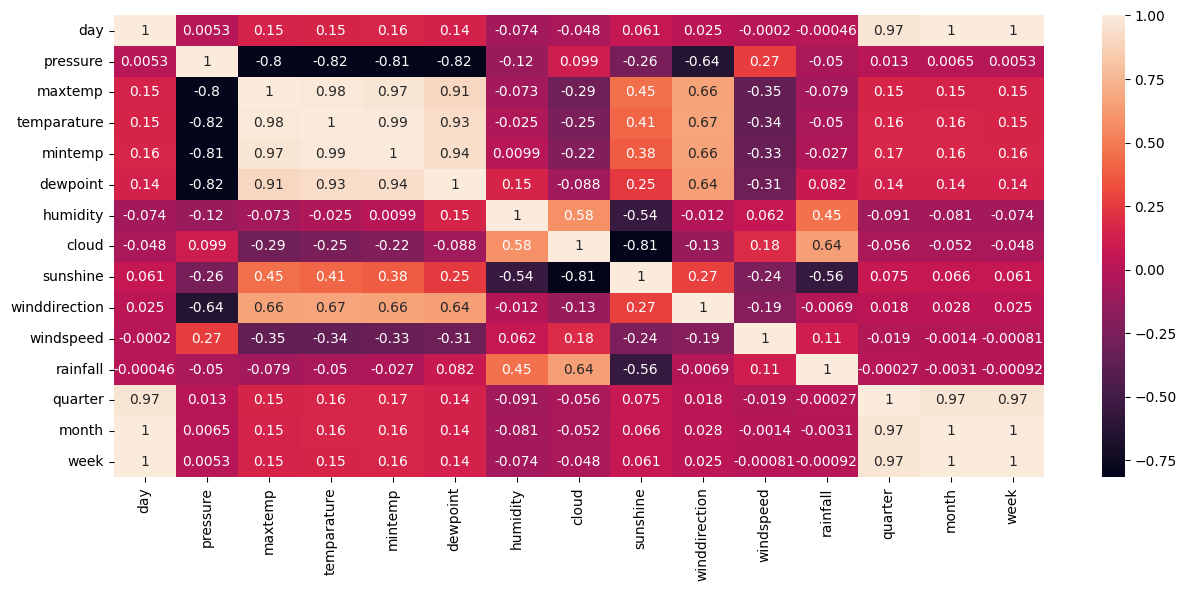

In [22]:
plt.figure(figsize=(15, 6))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [23]:
df.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',
       'rainfall', 'quarter', 'month', 'week'],
      dtype='object')

In [29]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from xgboost import XGBClassifier

X = df.drop('rainfall', axis=1)
y = df['rainfall']

pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('power_transform', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(
        # device="cuda",
        max_depth=6,  
        colsample_bytree=0.9, 
        subsample=0.9, 
        n_estimators=10_000,  
        learning_rate=0.1, 
        # eval_metric="auc",
        # early_stopping_rounds=100,
        alpha=1,
    ))
        # ('classifier',LogisticRegression(max_iter=1000, random_state=42))
    ])

scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
print(scores)
print(scores.mean())
print(scores.std())

[0.84678732 0.87811448 0.89003928 0.85973625 0.85238496]
0.8654124579124579
0.016227462042725845
